In [3]:
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import logging
import torch
import csv
from tqdm import tqdm
import anndata as ad
import scipy.sparse as sp
from scipy.io import mmwrite
from io import StringIO
from evaluate_results import get_ranked_pearson_corr
from evaluate_results import compute_rmse
from evaluate_results import get_ranked_spearman_corr
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from collections import defaultdict

import sys
import os

sys.path.append(os.path.join(sys.path[0], '../'))
from model.manager_for_sagittarius import Sagittarius_Manager

columns_metadata = pd.read_csv("../data_utils/data/static/GSE190147_scirnaseq_gene_matrix.columns.csv", delimiter="\t")
rows_metadata = pd.read_csv("../data_utils/data/static/GSE190147_scirnaseq_gene_matrix.rows.csv", delimiter="\t")
gene_expression_matrix = pd.read_csv("../data_utils/data/static/GSE190147_scirnaseq_gene_matrix.txt", delimiter=" ")
gene_expression_matrix_file = "../data_utils/data/static/GSE190147_scirnaseq_gene_matrix.txt"
columns_metadata_file = "../data_utils/data/static/GSE190147_scirnaseq_gene_matrix.columns.csv"
rows_metadata_file = "../data_utils/data/static/GSE190147_scirnaseq_gene_matrix.rows.csv"
gene_expression_mtx = "../data_utils/data/static/GSE190147_scirnaseq_gene_matrix.mtx"


In [4]:
# general setup cont...

# 5 timepoints
timepoints = ['hrs_00_02', 'hrs_01_03', 'hrs_02_04', 'hrs_03_07', 'hrs_04_08']

time_mapping = {
    'hrs_00_02': 0,
    'hrs_01_03': 1,
    'hrs_02_04': 2,
    'hrs_03_07': 3, 
    'hrs_04_08': 4, 
    'hrs_06_10': 5, 
    'hrs_08_12': 6,
    'hrs_10_14': 7,
    'hrs_12_16': 8, 
    'hrs_14_18': 9,
    'hrs_16_20': 10, 
}

# create mapping for the genes for train expr
# 'gene_types_dict.txt' - as created by create_gene_dict()

gene_types = {}
with open('../data_utils/data/static/GENES_MAPPING_FINAL.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(': ')
        key = parts[0].strip()
        value = int(parts[1].strip())
        gene_types[key] = value

In [6]:
# map cell id to seurat cluster for train

cell_type_mapping = {}
with open('../data_utils/data/exp1/seurat_clusters_dict.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(': ')
        key = parts[0].strip()
        value = int(parts[1].strip())
        cell_type_mapping[key] = value


In [7]:
# set up which indices cell ids will match to
# shouldn't matter as much though
"""

cell_id = {}
with open('cell_ids_dict.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(': ')
        key = parts[0].strip()
        value = int(parts[1].strip())
        cell_id[key] = value
"""


"\n\ncell_id = {}\nwith open('cell_ids_dict.txt', 'r') as file:\n    for line in file:\n        parts = line.strip().split(': ')\n        key = parts[0].strip()\n        value = int(parts[1].strip())\n        cell_id[key] = value\n"

In [8]:
# set up training inputs
N = 100 # number of samples
T = 1
M = len(gene_types)
expr = torch.zeros(N, T, M)
ys_tensor = torch.zeros(N, T)
ts = torch.zeros(N, T)

In [9]:
# main loop for populating expr
cell_id = set()

with open("../data_utils/data/exp1/exp1_filtered_matrix.csv", "r") as matrix_file:
    csv_reader = csv.reader(matrix_file)
    next(csv_reader)

    for line in tqdm(csv_reader, desc="Processing"):
        try:
            row_idx, col_idx, value = map(int, line)
                    
        except ValueError as ve:
            logging.error(f"Error parsing line: {line.strip()} - {ve}")
            continue
        
        tp = columns_metadata.iloc[col_idx, 4]
        
        cell_type = columns_metadata.iloc[col_idx, 0] # when i say cell_type i mean id
        gene_name = rows_metadata.iloc[row_idx - 2, 0]

        # sanity check
        # assert (expr[cell_id[cell_type] - 1, 0, gene_types[gene_name]] != 0)
        # assert(expr[[counter], 0, gene_types[gene_name]] != 0)
        cell_id.add(cell_type)
        expr[len(cell_id) - 1, 0, gene_types[gene_name]] = value
        ys_tensor[len(cell_id) - 1, 0] = cell_type_mapping[cell_type]
        ts[len(cell_id) - 1, 0] = time_mapping[tp]
        
print(len(cell_id))
ys = [ys_tensor]

Processing: 36333it [00:02, 15117.70it/s]

100


In [10]:
# create mask
mask = torch.zeros(N, T)
for i in range(N):
    for j in range(T):
        if not (expr[i, j, :] == 0).all():
            mask[i, j] = 1

In [11]:
manager = Sagittarius_Manager(
    input_dim=M,
    num_classes=1, 
    class_sizes=[54],
    cvae_catdims=[2],
    cvae_hiddendims=[128, 64],
    cvae_ld=32,
    attn_heads=4,
    num_ref_points=10,
    temporal_dim=16,
    tr_catdims=[8],
    minT=0,
    maxT=10, 
    device='cpu',
    transformer_dim=None, # Not using encoder/decoder for this experiment
    batch_size=16,
    beta=1.0,
    train_transfer=False, 
    num_cont=1, # Only continuous variable is time
    rec_loss='mse'
)

weights = 'weights/131055exp1.pth'
manager.train_model(expr, ts, ys, mask, reload=False, mfile=weights, num_epochs=1000, lr=0.001)

h


  0%|                                                  | 0/1000 [00:00<?, ?it/s]/homes/gws/jc383/WindowsFolders/Desktop/DrosSag/training/../model/manager_for_sagittarius.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(expr[bstart:bend], dtype=torch.float32).to(self.device) # Numpy don't have Float, unlike tensors
/homes/gws/jc383/WindowsFolders/Desktop/DrosSag/lib64/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|███████████████████████████████████████| 1000/1000 [01:41<00:00,  9.88it/s]


{'loss': [1.218471884727478, 1.129655361175537, 0.7868343591690063, 0.6036924123764038, 0.5350623726844788, 0.4868341088294983, 0.45917248725891113, 0.44201961159706116, 0.4287068247795105, 0.4181930422782898, 0.40941479802131653, 0.4072996973991394, 0.4027067720890045, 0.39839959144592285, 0.39368247985839844, 0.39461833238601685, 0.3887925148010254, 0.3873707056045532, 0.3951784372329712, 0.39460301399230957, 0.3962509036064148, 0.3958551287651062, 0.38302671909332275, 0.3764115571975708, 0.3719795048236847, 0.3726796507835388, 0.36864644289016724, 0.3754875659942627, 0.3701867461204529, 0.3647933900356293, 0.3697494864463806, 0.3668202757835388, 0.3721282482147217, 0.36604630947113037, 0.3662182092666626, 0.36370083689689636, 0.3650979995727539, 0.363781213760376, 0.3657630980014801, 0.36887189745903015, 0.36710458993911743, 0.36958402395248413, 0.36579403281211853, 0.36317500472068787, 0.3578029274940491, 0.36429402232170105, 0.3581642210483551, 0.3616487383842468, 0.36157172918319

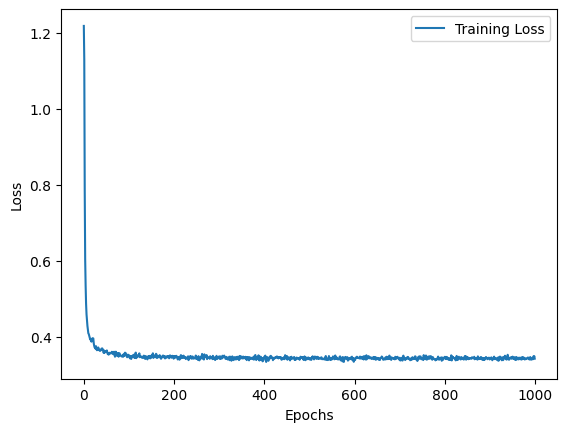

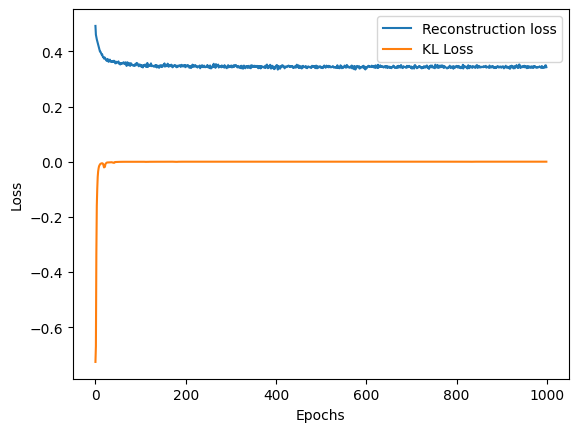

In [12]:
#loss curves

print(manager.train_losses)
plt.plot(manager.train_losses['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


reconstruction_losses = manager.train_losses['MSE']
kld_losses = manager.train_losses['KLD']
plt.plot(reconstruction_losses, label='Reconstruction loss')
plt.plot(kld_losses, label='KL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# set up test set training

N = 100 # number of samples
T = 1
M = len(gene_types)
test_expr = torch.zeros(N, T, M)
test_ys_tensor = torch.zeros(N, T)
test_ts = torch.zeros(N, T)

cell_type_mapping = {}
with open('../data_utils/data/exp1/seurat_clusters_dict_TEST.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(': ')
        key = parts[0].strip()
        value = int(parts[1].strip())
        cell_type_mapping[key] = value

cell_id = set()
with open("../data_utils/data/exp1/exp1_filtered_matrix_TEST.csv", "r") as matrix_file:
    csv_reader = csv.reader(matrix_file)
    next(csv_reader)

    for line in tqdm(csv_reader, desc="Processing"):
        try:
            row_idx, col_idx, value = map(int, line)
                    
        except ValueError as ve:
            logging.error(f"Error parsing line: {line.strip()} - {ve}")
            continue
        
        tp = columns_metadata.iloc[col_idx, 4]
        
        cell_type = columns_metadata.iloc[col_idx, 0] # when i say cell_type i mean id
        gene_name = rows_metadata.iloc[row_idx - 2, 0]

        cell_id.add(cell_type)
        test_expr[len(cell_id) - 1, 0, gene_types[gene_name]] = value
        test_ys_tensor[len(cell_id) - 1, 0] = cell_type_mapping[cell_type]
        test_ts[len(cell_id) - 1, 0] = time_mapping[tp]
        
print(len(cell_id))
test_ys = [test_ys_tensor]
test_mask = torch.zeros(N, T)
for i in range(N):
    for j in range(T):
        if not (test_expr[i, j, :] == 0).all():
            test_mask[i, j] = 1

In [ ]:
manager = Sagittarius_Manager(
    input_dim=M,
    num_classes=1, 
    class_sizes=[54],
    cvae_catdims=[2],
    cvae_hiddendims=[128, 64],
    cvae_ld=32,
    attn_heads=4,
    num_ref_points=10,
    temporal_dim=16,
    tr_catdims=[8],
    minT=0,
    maxT=10, 
    device='cpu',
    transformer_dim=None, # Not using encoder/decoder for this experiment
    batch_size=16,
    beta=1.0,
    train_transfer=False, 
    num_cont=1, # Only continuous variable is time
    rec_loss='mse'
)
weights = 'weights/11313exp1.pth'
manager.train_model(test_expr, test_ts, test_ys, test_mask, reload=True, mfile=weights)
newpred = manager.reconstruct()
print(newpred.shape)

# hold a copy
pred = newpred

gt = test_expr
gt = torch.masked_select(test_expr,torch.stack([test_mask.bool() for _ in range(M)], dim = -1)).view(-1, M)

# at this point pred = newpred, gt and pred have the same dimensions and are 2D

In [9]:
correlation = get_ranked_spearman_corr(pred, gt, get_per_sequence=False)
print(correlation)
correlation = get_ranked_spearman_corr(pred, gt, get_per_sequence=True)
print(correlation)

100
0.11508401258946405
100
[0.15550637355168842, 0.06170364929308176, 0.10216220299980368, 0.14299815267573587, 0.11642436577933772, 0.06742285552140033, 0.11104187076398406, 0.07007709999623618, 0.04522622858786493, 0.07392862928523647, 0.08085432990664825, 0.11686862540265339, 0.08912046102800378, 0.06706105081191067, 0.10693432554178209, 0.08906207187892737, 0.09739005793736824, 0.0842199573498472, 0.10882773284840935, 0.08306393384553477, 0.0762117452948719, 0.10827635167679925, 0.07800673986548173, 0.11902624133267935, 0.1320822742446721, 0.18201350177763898, 0.13317451158783697, 0.12229131190813679, 0.13502497053573412, 0.06283345745992183, 0.12745765974751702, 0.07615955588235483, 0.07249716656297661, 0.15303069722115928, 0.0959812128913499, 0.20947970350862163, 0.15850077652056302, 0.0915057312117078, 0.12097532608761145, 0.05902920008419654, 0.11051729880417492, 0.1778546101232591, 0.14169371893613172, 0.18024355480188134, 0.19635614820596128, 0.08819111635708991, 0.138161087

In [10]:
# individual statistics for spearman

gt_copy = gt
pred_copy = pred

avg_st = []

for i in range(N):

        # check if this timepoint is associated with values
    if not torch.all(gt_copy[i] == 0):
        gene_ex_vec = gt_copy[i]
        pred_ex_vec = pred_copy[i]
        nonzero_mask = torch.where(gene_ex_vec != 0, 1, 0)
        partial_gene_ex = torch.masked_select(gene_ex_vec, nonzero_mask.bool())
        partial_pred_ex = torch.masked_select(pred_ex_vec, nonzero_mask.bool())

        # check correlation to compute
        if len(partial_gene_ex) > 1:
            avg_st.append(spearmanr(partial_gene_ex.detach().numpy(), partial_pred_ex.detach().numpy()))
print(avg_st)
print(len(avg_st))

[SignificanceResult(statistic=0.18818051603761818, pvalue=0.0008865586631080849), SignificanceResult(statistic=0.11330052796530433, pvalue=0.14610468458467082), SignificanceResult(statistic=0.09845469226297585, pvalue=0.0706444271670863), SignificanceResult(statistic=0.149132868595085, pvalue=0.0030781932508628317), SignificanceResult(statistic=0.08017586418573418, pvalue=0.16889070599985673), SignificanceResult(statistic=0.12668520622749901, pvalue=0.06496885866692), SignificanceResult(statistic=0.13151901037507205, pvalue=0.0030076310220041396), SignificanceResult(statistic=0.07433980121617641, pvalue=0.2700653872295755), SignificanceResult(statistic=0.057154776908086125, pvalue=0.45644033717467036), SignificanceResult(statistic=0.042999805381224374, pvalue=0.44915200845793246), SignificanceResult(statistic=0.15552661442598775, pvalue=0.005228135536517838), SignificanceResult(statistic=0.220549101039807, pvalue=2.2366537060143623e-05), SignificanceResult(statistic=0.1812456105095557,

In [5]:
# set up val set #1

N = 100 # number of samples
T = 1
M = len(gene_types)
val1_expr = torch.zeros(N, T, M)
val1_ys_tensor = torch.zeros(N, T)
val1_ts = torch.zeros(N, T)

cell_type_mapping = {}
with open('../data_utils/data/exp1/seurat_clusters_dict_VAL1.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(': ')
        key = parts[0].strip()
        value = int(parts[1].strip())
        cell_type_mapping[key] = value

cell_id = set()
with open("../data_utils/data/exp1/exp1_filtered_matrix_VAL1.csv", "r") as matrix_file:
    csv_reader = csv.reader(matrix_file)
    next(csv_reader)

    for line in tqdm(csv_reader, desc="Processing"):
        try:
            row_idx, col_idx, value = map(int, line)
                    
        except ValueError as ve:
            logging.error(f"Error parsing line: {line.strip()} - {ve}")
            continue
        
        tp = columns_metadata.iloc[col_idx, 4]
        
        cell_type = columns_metadata.iloc[col_idx, 0] # when i say cell_type i mean id
        gene_name = rows_metadata.iloc[row_idx - 2, 0]

        cell_id.add(cell_type)
        val1_expr[len(cell_id) - 1, 0, gene_types[gene_name]] = value
        val1_ys_tensor[len(cell_id) - 1, 0] = cell_type_mapping[cell_type]
        val1_ts[len(cell_id) - 1, 0] = time_mapping[tp]
        
print(len(cell_id))
val1_ys = [val1_ys_tensor]
val1_mask = torch.zeros(N, T)
for i in range(N):
    for j in range(T):
        if not (val1_expr[i, j, :] == 0).all():
            val1_mask[i, j] = 1

Processing: 37564it [00:02, 15353.86it/s]

100


In [6]:
manager = Sagittarius_Manager(
    input_dim=M,
    num_classes=1, 
    class_sizes=[54],
    cvae_catdims=[2],
    cvae_hiddendims=[128, 64],
    cvae_ld=32,
    attn_heads=4,
    num_ref_points=10,
    temporal_dim=16,
    tr_catdims=[8],
    minT=0,
    maxT=10, 
    device='cpu',
    transformer_dim=None, # Not using encoder/decoder for this experiment
    batch_size=16,
    beta=1.0,
    train_transfer=False, 
    num_cont=1, # Only continuous variable is time
    rec_loss='mse'
)
weights = 'weights/131055exp1.pth'
manager.train_model(val1_expr, val1_ts, val1_ys, val1_mask, reload=True, mfile=weights)
newpred = manager.reconstruct()
print(newpred.shape)

# hold a copy
pred = newpred

gt = val1_expr
gt = torch.masked_select(val1_expr,torch.stack([val1_mask.bool() for _ in range(M)], dim = -1)).view(-1, M)

# at this point pred = newpred, gt and pred have the same dimensions and are 2D

/homes/gws/jc383/WindowsFolders/Desktop/DrosSag/lib64/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


h
torch.Size([100, 21216])


In [7]:
# individual statistics for spearman (non-zero genes)

gt_copy = gt
pred_copy = pred

avg_st = []

for i in range(N):

        # check if this timepoint is associated with values
    if not torch.all(gt_copy[i] == 0):
        gene_ex_vec = gt_copy[i]
        pred_ex_vec = pred_copy[i]
        nonzero_mask = torch.where(gene_ex_vec != 0, 1, 0)
        partial_gene_ex = torch.masked_select(gene_ex_vec, nonzero_mask.bool())
        partial_pred_ex = torch.masked_select(pred_ex_vec, nonzero_mask.bool())

        # check correlation to compute
        if len(partial_gene_ex) > 1:
            avg_st.append(spearmanr(partial_gene_ex.detach().numpy(), partial_pred_ex.detach().numpy()))
print(avg_st)
print(len(avg_st))

[SignificanceResult(statistic=0.17339376401208798, pvalue=2.477408232588013e-05), SignificanceResult(statistic=-0.029160712637722616, pvalue=0.682643865372748), SignificanceResult(statistic=0.14310768255512468, pvalue=0.010016560231778845), SignificanceResult(statistic=0.12859342051351025, pvalue=0.05629175451943697), SignificanceResult(statistic=0.20293415242311488, pvalue=0.004335651304205867), SignificanceResult(statistic=0.14439715456841823, pvalue=0.0205731579623701), SignificanceResult(statistic=0.07523722813990465, pvalue=0.21191954219479503), SignificanceResult(statistic=0.22578198065944374, pvalue=4.584506013563084e-05), SignificanceResult(statistic=0.12415498976561189, pvalue=0.04507888991789376), SignificanceResult(statistic=0.19225858962584055, pvalue=0.0017701236482474138), SignificanceResult(statistic=0.18673162826342635, pvalue=0.0011128820661797942), SignificanceResult(statistic=0.1830643798715705, pvalue=0.00487485219977004), SignificanceResult(statistic=0.198982724521

In [ ]:
correlation = get_ranked_spearman_corr(pred, gt, get_per_sequence=False)
print(correlation)
correlation = get_ranked_spearman_corr(pred, gt, get_per_sequence=True)
print(correlation)

100
0.32972864710422833
100
